In [5]:
# ==================================================
# VNFootballGraph - Tự động mở rộng mạng từ 1 node
# ==================================================
import wikipediaapi
import networkx as nx
import pandas as pd
from tqdm import tqdm
import os

# ---------------------------------------------
# 1️⃣ Cấu hình ban đầu
# ---------------------------------------------
SEED_NODE = "Nguyễn Quang Hải (sinh 1997)"
MAX_DEPTH = 3          # độ sâu mở rộng
MAX_NODES = 1500       # giới hạn tổng node để tránh vòng lặp
OUTPUT_DIR = "data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=== VNFootballGraph Auto Expansion ===")
print(f"Seed node: {SEED_NODE}")
print(f"Max depth: {MAX_DEPTH}, Max nodes: {MAX_NODES}")


=== VNFootballGraph Auto Expansion ===
Seed node: Nguyễn Quang Hải (sinh 1997)
Max depth: 3, Max nodes: 1500


In [6]:
# ---------------------------------------------
# 2️⃣ Khởi tạo Wikipedia API
# ---------------------------------------------
wiki = wikipediaapi.Wikipedia(
    language='vi',
    user_agent='VNFootballGraph/1.4 (contact: longha6104@gmail.com)'
)
print("Wikipedia API sẵn sàng.")


Wikipedia API sẵn sàng.


In [7]:
# ---------------------------------------------
# 3️⃣ Hàm hỗ trợ
# ---------------------------------------------
def get_links(title):
    """Trả về danh sách liên kết nội bộ của 1 trang (tự nhận redirect)"""
    page = wiki.page(title)
    if not page.exists():
        print(f"⚠️ Trang không tồn tại: {title}")
        return []
    # Nếu bị redirect sang trang khác
    if page.title != title:
        print(f"🔁 Redirected: {title} → {page.title}")
    return list(page.links.keys())


def auto_expand(seed, max_depth=3, max_nodes=1500):
    """
    Tự động mở rộng mạng Wikipedia (BFS)
    """
    G = nx.DiGraph()
    visited = set()
    queue = [(seed, 0)]

    while queue:
        node, depth = queue.pop(0)
        if node in visited or len(G.nodes()) >= max_nodes:
            continue
        visited.add(node)
        if depth > max_depth:
            break

        links = get_links(node)
        for l in links:
            G.add_edge(node, l)
            if l not in visited:
                queue.append((l, depth + 1))

        print(f"[Depth {depth}] {node} → {len(links)} links | Tổng node: {len(G.nodes())}")
    return G


In [8]:
# ---------------------------------------------
# 4️⃣ Thực thi mở rộng
# ---------------------------------------------
print(f"\n🌱 Bắt đầu mở rộng từ: {SEED_NODE}")
G = auto_expand(SEED_NODE, MAX_DEPTH, MAX_NODES)

print("\n✅ Hoàn tất mở rộng.")
print(f"Tổng số node: {len(G.nodes())}")
print(f"Tổng số cạnh: {len(G.edges())}")



🌱 Bắt đầu mở rộng từ: Nguyễn Quang Hải (sinh 1997)
[Depth 0] Nguyễn Quang Hải (sinh 1997) → 362 links | Tổng node: 363
🔁 Redirected: AFC Asian Cup 2019 → Cúp bóng đá châu Á 2019
[Depth 1] AFC Asian Cup 2019 → 642 links | Tổng node: 958
🔁 Redirected: AFC Champions League → AFC Champions League Elite
[Depth 1] AFC Champions League → 347 links | Tổng node: 1249
🔁 Redirected: AFC Cup 2019 → Cúp AFC 2019
[Depth 1] AFC Cup 2019 → 267 links | Tổng node: 1468
🔁 Redirected: ASEAN Championship 2024 → Giải vô địch bóng đá ASEAN 2024
[Depth 1] ASEAN Championship 2024 → 265 links | Tổng node: 1651

✅ Hoàn tất mở rộng.
Tổng số node: 1651
Tổng số cạnh: 1883


In [9]:
# ---------------------------------------------
# 5️⃣ Lưu kết quả node & edge
# ---------------------------------------------
edges_df = pd.DataFrame(G.edges(), columns=["source", "target"])
nodes_df = pd.DataFrame(G.nodes(), columns=["node"])

edges_df.to_csv(os.path.join(OUTPUT_DIR, "auto_expanded_edges.csv"), index=False)
nodes_df.to_csv(os.path.join(OUTPUT_DIR, "auto_expanded_nodes.csv"), index=False)

print("📦 Dữ liệu đã lưu:")
print(f"- auto_expanded_edges.csv ({len(edges_df)} cạnh)")
print(f"- auto_expanded_nodes.csv ({len(nodes_df)} node)")


📦 Dữ liệu đã lưu:
- auto_expanded_edges.csv (1883 cạnh)
- auto_expanded_nodes.csv (1651 node)


In [10]:
# ---------------------------------------------
# 6️⃣ Kiểm tra kết quả
# ---------------------------------------------
print("\nVí dụ 5 node đầu tiên:")
print(nodes_df.head())

print("\nVí dụ 5 cạnh đầu tiên:")
print(edges_df.head())

# Kiểm tra node gốc có tồn tại trong mạng
if SEED_NODE in nodes_df["node"].values:
    print(f"\n✅ Node gốc '{SEED_NODE}' tồn tại trong mạng.")
else:
    print(f"\n⚠️ Node gốc '{SEED_NODE}' không xuất hiện trong mạng.")



Ví dụ 5 node đầu tiên:
                           node
0  Nguyễn Quang Hải (sinh 1997)
1            AFC Asian Cup 2019
2          AFC Champions League
3                  AFC Cup 2019
4       ASEAN Championship 2024

Ví dụ 5 cạnh đầu tiên:
                         source                   target
0  Nguyễn Quang Hải (sinh 1997)       AFC Asian Cup 2019
1  Nguyễn Quang Hải (sinh 1997)     AFC Champions League
2  Nguyễn Quang Hải (sinh 1997)             AFC Cup 2019
3  Nguyễn Quang Hải (sinh 1997)  ASEAN Championship 2024
4  Nguyễn Quang Hải (sinh 1997)                   Al Ain

✅ Node gốc 'Nguyễn Quang Hải (sinh 1997)' tồn tại trong mạng.


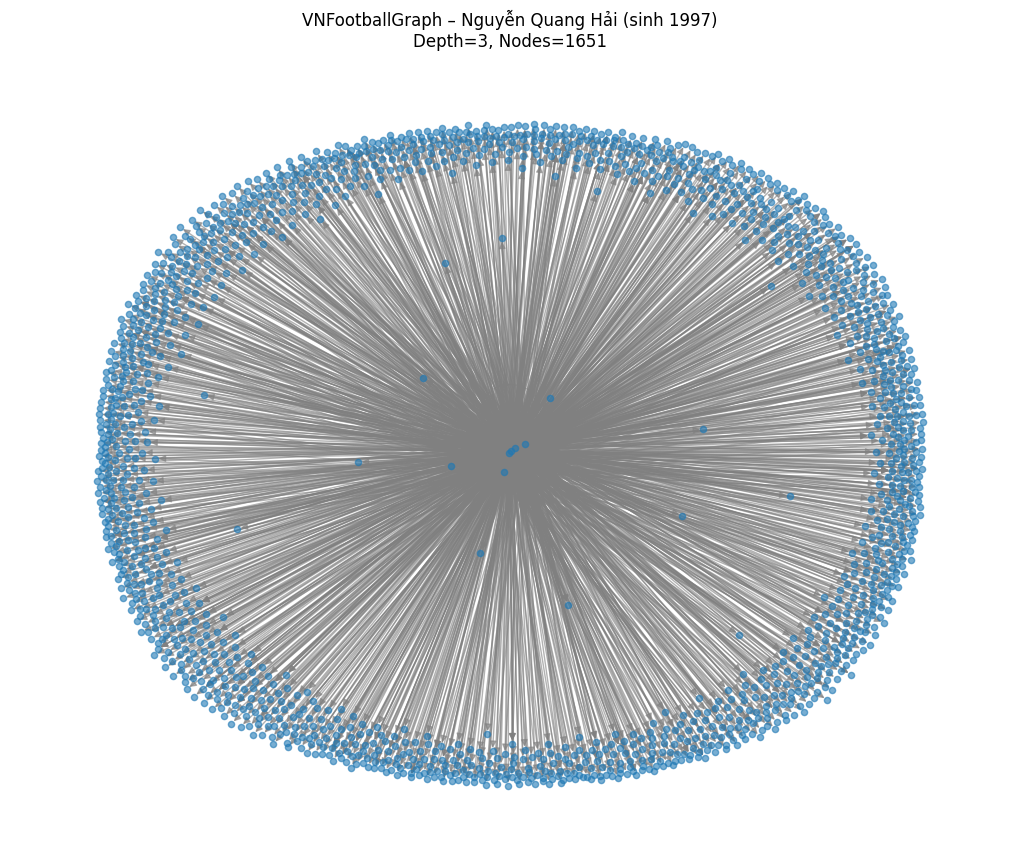

In [11]:
# ---------------------------------------------
# 7️⃣ Trực quan hóa đồ thị (tùy chọn)
# ---------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", alpha=0.6)
plt.title(f"VNFootballGraph – {SEED_NODE}\nDepth={MAX_DEPTH}, Nodes={len(G.nodes())}")
plt.show()


In [12]:
# ==================================================
# 8️⃣ Xuất đồ thị ra file (tùy chọn định dạng)
# ==================================================
import networkx as nx
import json
import pickle
import os

GRAPH_PATH = "data/graph_exports"
os.makedirs(GRAPH_PATH, exist_ok=True)

# 1️⃣ Xuất sang GraphML (chuẩn của Gephi, Cytoscape)
nx.write_graphml(G, os.path.join(GRAPH_PATH, "VNFootballGraph.graphml"))
print("✅ Đã lưu file: VNFootballGraph.graphml")

# 2️⃣ Xuất sang GEXF (Gephi, NetworkX hỗ trợ)
nx.write_gexf(G, os.path.join(GRAPH_PATH, "VNFootballGraph.gexf"))
print("✅ Đã lưu file: VNFootballGraph.gexf")

# 3️⃣ Xuất sang JSON (để dùng trong web hoặc D3.js)
graph_data = nx.node_link_data(G)
with open(os.path.join(GRAPH_PATH, "VNFootballGraph.json"), "w", encoding="utf-8") as f:
    json.dump(graph_data, f, ensure_ascii=False, indent=2)
print("✅ Đã lưu file: VNFootballGraph.json")

# 4️⃣ Xuất sang Pickle (tải lại bằng Python nhanh)
with open(os.path.join(GRAPH_PATH, "VNFootballGraph.pkl"), "wb") as f:
    pickle.dump(G, f)
print("✅ Đã lưu file: VNFootballGraph.pkl")

print(f"\n📁 Tất cả file đã lưu trong: {GRAPH_PATH}")


✅ Đã lưu file: VNFootballGraph.graphml
✅ Đã lưu file: VNFootballGraph.gexf
✅ Đã lưu file: VNFootballGraph.json
✅ Đã lưu file: VNFootballGraph.pkl

📁 Tất cả file đã lưu trong: data/graph_exports


/home/longha/miniforge3/envs/datamining/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
